Nesessary imports:

In [40]:
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt

Loading images and labeled vessels:

In [41]:
image_list = []
for filename in sorted(glob.glob('stare-images/*.ppm')):
    im= cv2.imread(filename)
    image_list.append(im)

image_labeled_list = []
for filename in sorted(glob.glob('stare-images-labeled/*.ppm')):
    im= cv2.imread(filename,0)
    image_labeled_list.append(im)

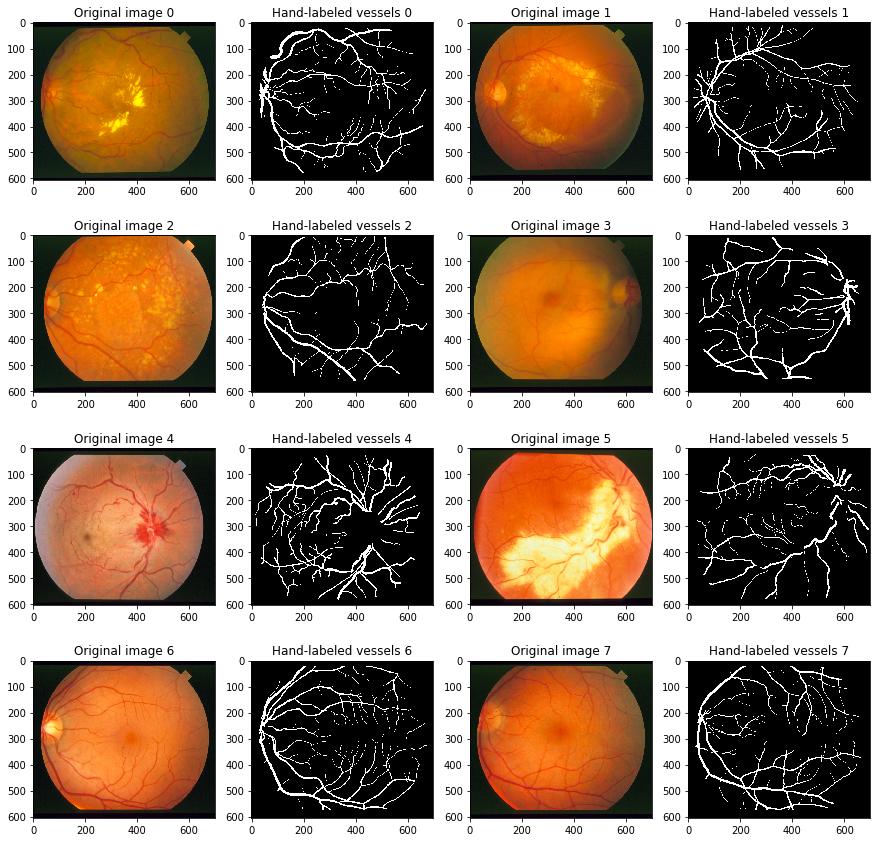

In [205]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if (i+1)%2:
        img = image_list[int(i/2)]
        plt.title("Original image %d" % int(i/2))
        plt.imshow(img[:,:,::-1])
    else:
        img = image_labeled_list[int(i/2)]
        plt.title("Hand-labeled vessels %d" % int(i/2))
        plt.imshow(img, cmap='gray')
plt.show()

Loading example image we will work on:

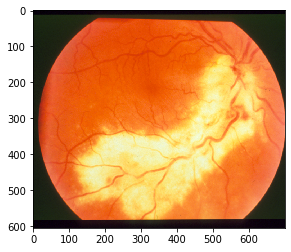

In [207]:
image = image_list[5]
plt.imshow(image[:,:,::-1])

Separating the color channels to see which channel seems to show the vessels best:

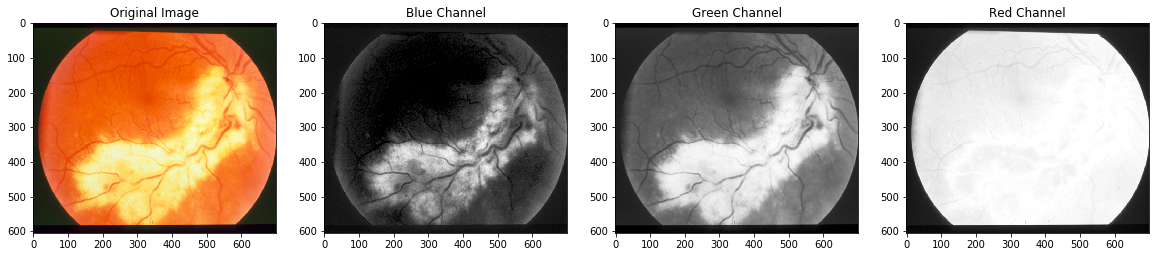

In [208]:
image_blue = image[:,:,0]
image_green = image[:,:,1]
image_red = image[:,:,2]

plt.figure(figsize=(20,12))
plt.subplot(141)
plt.imshow(image[:,:,::-1]);
plt.title("Original Image")
plt.subplot(142)
plt.imshow(image_blue, cmap='gray');
plt.title("Blue Channel")
plt.subplot(143)
plt.imshow(image_green, cmap='gray');
plt.title("Green Channel")
plt.subplot(144)
plt.imshow(image_red, cmap='gray');
plt.title("Red Channel");

Equalizing the histogram of image using Contrast Limited Adaptive Histogram Equalization:

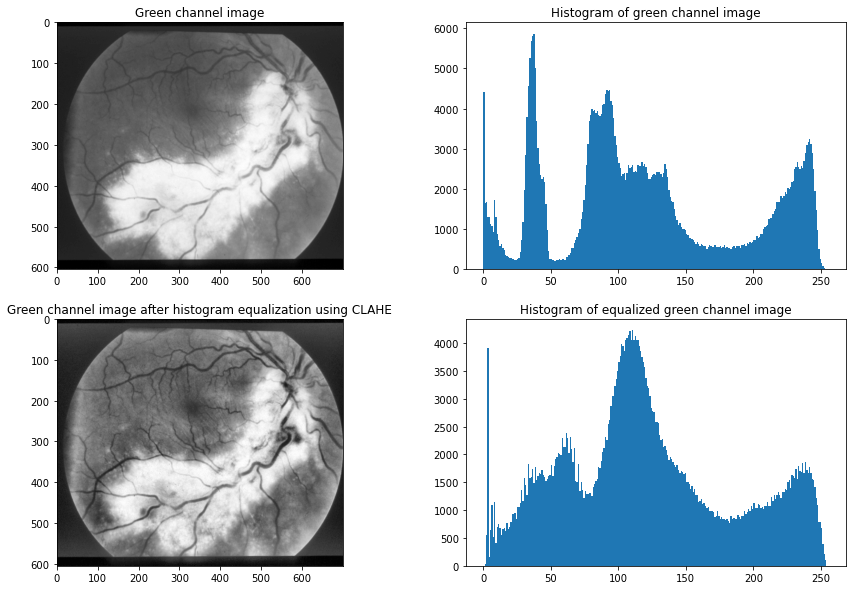

In [24]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image_green_equalized = clahe.apply(image_green)

fig=plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(image_green, cmap='gray')
plt.title("Green channel image")
plt.subplot(222)
plt.hist(image_green.ravel(),256,[0,256])
plt.title("Histogram of green channel image")

plt.subplot(223)
plt.imshow(image_green_equalized, cmap='gray')
plt.title("Green channel image after histogram equalization using CLAHE")
plt.subplot(224)
plt.hist(image_green_equalized.ravel(),256,[0,256])
plt.title("Histogram of equalized green channel image")

plt.show()

Using the technique from chapters 4.2.2 and 4.3.2 from: "Deserno, T. M. (2011). Biomedical image processing.":

First we extract the "background" of the vessels using morphological operations:

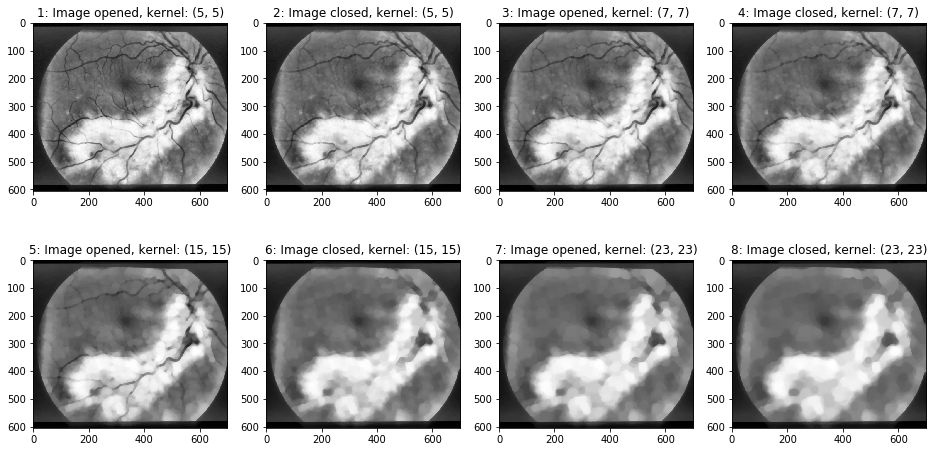

In [210]:
kernel_sizes = [5,7,15,23]
kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

morphology_steps = [image_green_equalized.copy()]
for kernel in kernels:
    image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
    image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
    morphology_steps.extend([image_opened, image_closed])

fig=plt.figure(figsize=(16, 8))
rows = 2
columns = len(kernels)
for i in range(1, len(morphology_steps)):
    img = morphology_steps[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    kernel_size = kernel_sizes[math.ceil(i/2)-1]
    if i%2==1:
        plt.title("%d: Image opened, kernel: (%d, %d)" % (i, kernel_size, kernel_size))
    else:
        plt.title("%d: Image closed, kernel: (%d, %d)" % (i, kernel_size, kernel_size))
plt.show()

Next we subtract this background from our images (technically we do the opossite due to the white pixels being the biggest value):

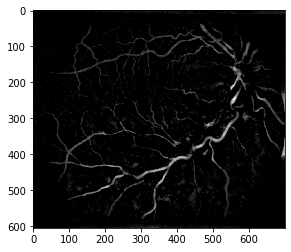

In [211]:
extracted_vessels = cv2.subtract(morphology_steps[-1],image_green_equalized)
plt.imshow(extracted_vessels, cmap='gray')

Equalizing the histogram of image using Contrast Limited Adaptive Histogram Equalization:

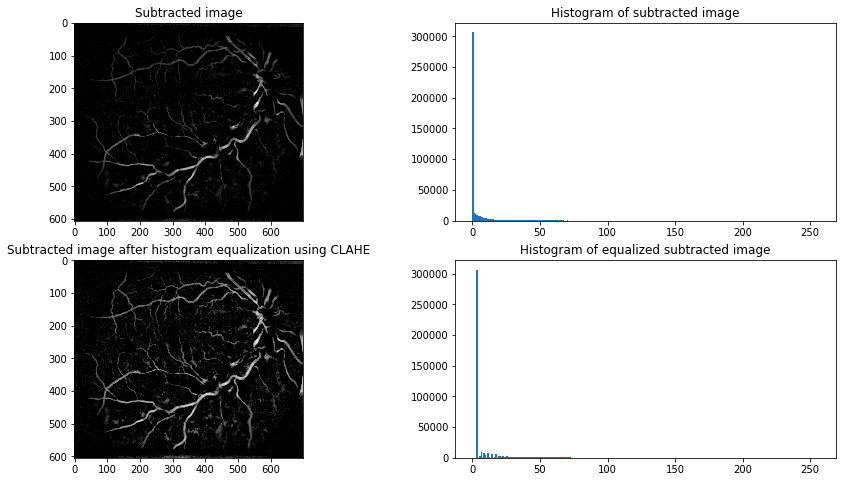

In [212]:
extracted_vessels_equalized = clahe.apply(extracted_vessels)

fig=plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.imshow(extracted_vessels, cmap='gray')
plt.title("Subtracted image")
plt.subplot(222)
plt.hist(extracted_vessels.ravel(),256,[0,256])
plt.title("Histogram of subtracted image")

plt.subplot(223)
plt.imshow(extracted_vessels_equalized, cmap='gray')
plt.title("Subtracted image after histogram equalization using CLAHE")
plt.subplot(224)
plt.hist(extracted_vessels_equalized.ravel(),256,[0,256])
plt.title("Histogram of equalized subtracted image")

plt.show()

We try to threshold the vessels:

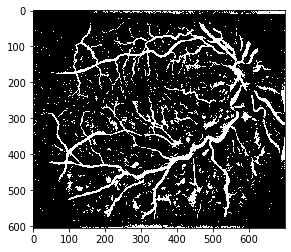

In [213]:
ret,extracted_vessels_equalized_threshold = cv2.threshold(extracted_vessels_equalized,20,255,cv2.THRESH_BINARY)
plt.imshow(extracted_vessels_equalized_threshold,cmap='gray')

We see that there is a lot of noise we need to get rid of. Fortunately we know, that the vessels are connected in pretty long lines, so we can filter out the noise using the area of contours.

We start by creating our mask:

(605, 700)


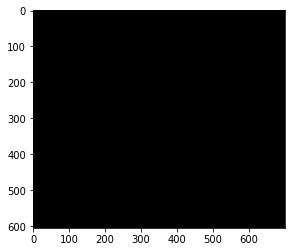

In [214]:
noise_mask = np.ones(extracted_vessels_equalized.shape[:2], dtype="uint8") * 255
plt.imshow(noise_mask,cmap='gray')
print(np.shape(noise_mask))

Next we draw all the contours we want to get rid of, so the ones which area is below some threshold value:

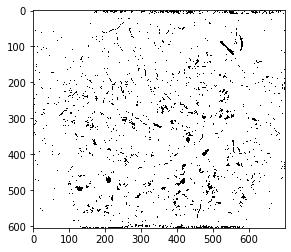

In [215]:
contours, hierarchy = cv2.findContours(extracted_vessels_equalized_threshold.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    if cv2.contourArea(contour) <= 200:
        cv2.drawContours(noise_mask, [contour], -1, 0, -1)
plt.imshow(noise_mask, cmap='gray')

We use the mask on our image using bitwise and operation:

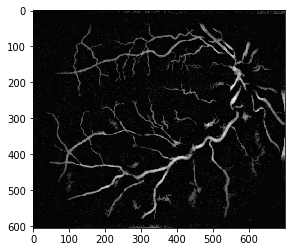

In [216]:
extracted_vessels_corrected = cv2.bitwise_and(extracted_vessels_equalized, extracted_vessels_equalized, mask=noise_mask)
plt.imshow(extracted_vessels_corrected, cmap='gray')

We try to threshold the vessels again:

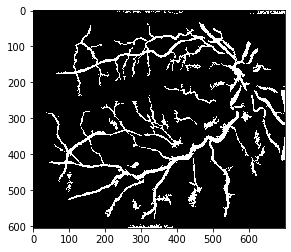

In [217]:
ret,extracted_vessels_corrected_thresholded = cv2.threshold(extracted_vessels_corrected,20,255,cv2.THRESH_BINARY)
plt.imshow(extracted_vessels_corrected_thresholded, cmap='gray')

As we can see, the results are pretty good, considering this is an only image processing approach.

We pack our approach in the one function:

In [218]:
def get_vessels(image, kernel_sizes = [5,7,15,21], thresh_val=20, max_noise_area=200):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    image_green = image[:,:,1]
    image_green_equalized = clahe.apply(image_green)
    
    kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

    morphology_steps = [image_green_equalized.copy()]
    for kernel in kernels:
        image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
        image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
        morphology_steps.extend([image_opened, image_closed])

    extracted_vessels = cv2.subtract(morphology_steps[-1],image_green_equalized)
    extracted_vessels_equalized = clahe.apply(extracted_vessels)
    _, extracted_vessels_equalized_threshold = cv2.threshold(extracted_vessels_equalized,thresh_val,255,cv2.THRESH_BINARY)
    
    noise_mask = np.ones(extracted_vessels_equalized_threshold.shape[:2], dtype="uint8") * 255

    contours, hierarchy = cv2.findContours(extracted_vessels_equalized_threshold.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= max_noise_area:
            cv2.drawContours(noise_mask, [contour], -1, 0, -1)

    extracted_vessels_corrected = cv2.bitwise_and(extracted_vessels_equalized, extracted_vessels_equalized, mask=noise_mask)
    _, extracted_vessels_corrected_thresholded = cv2.threshold(extracted_vessels_corrected,thresh_val,255,cv2.THRESH_BINARY)
    return extracted_vessels_corrected_thresholded

Calculating for our images:

In [219]:
image_processed_list = [get_vessels(image) for image in image_list]

Showing the results together with target results:

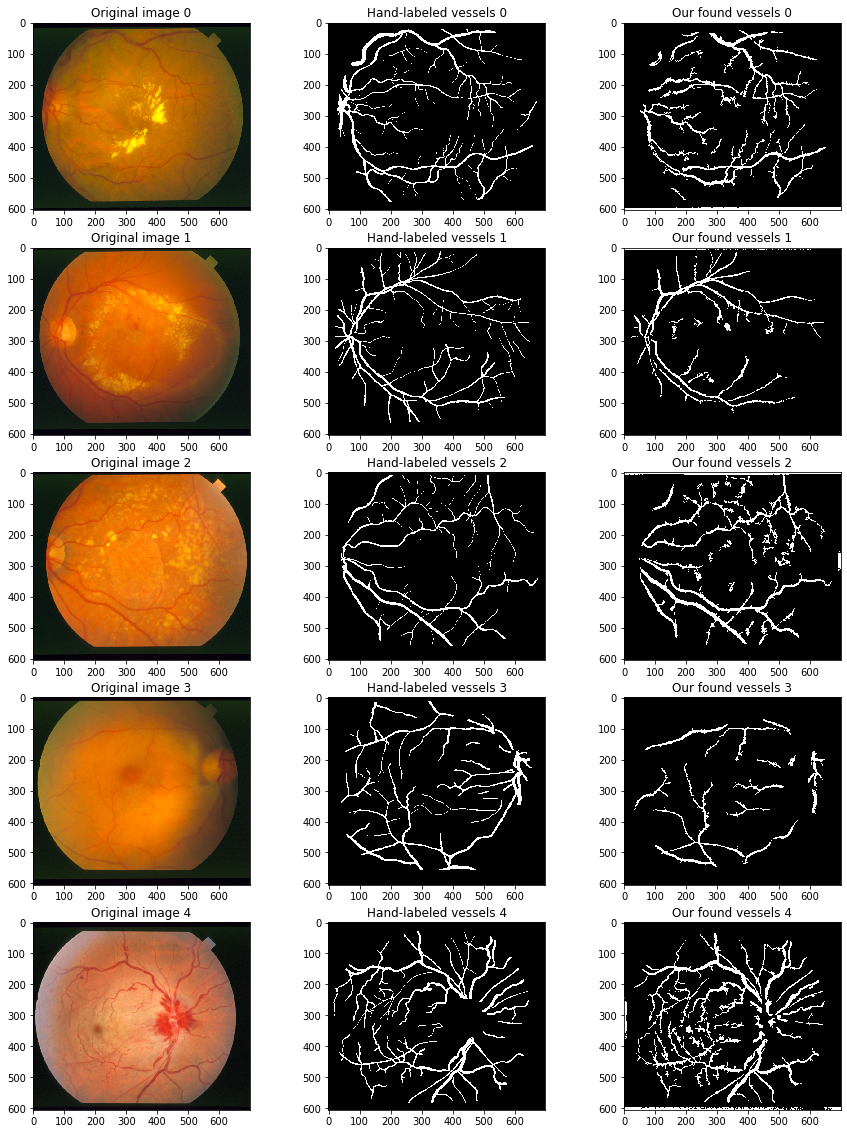

In [221]:
fig=plt.figure(figsize=(15, 20))
columns = 3
rows = 5
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if i%3==0:
        img = image_list[int(i/3)]
        plt.title("Original image %d" % int(i/3))
        plt.imshow(img[:,:,::-1])
    elif i%3==1:
        img = image_labeled_list[int(i/3)]
        plt.title("Hand-labeled vessels %d" % int(i/3))
        plt.imshow(img, cmap='gray')
    else:
        img = image_processed_list[int(i/3)]
        plt.title("Our found vessels %d" % int(i/3))
        plt.imshow(img, cmap='gray')
plt.show()

Now we write function to calculate our metrics:

In [222]:
from sklearn.metrics import confusion_matrix

In [223]:
def geo_mean(val1, val2):
    return (val1*val2)**(1.0/2)

def get_metrics(img_test, img_pred):
    conf = confusion_matrix(img_test.flatten(), img_pred.flatten())
    TN, FP, FN, TP = conf.ravel()
    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    geo_mean_val = geo_mean(sensitivity, specificity)
    
    return (accuracy, sensitivity, specificity, geo_mean_val)

Plot out 5 testing images together with metrics:

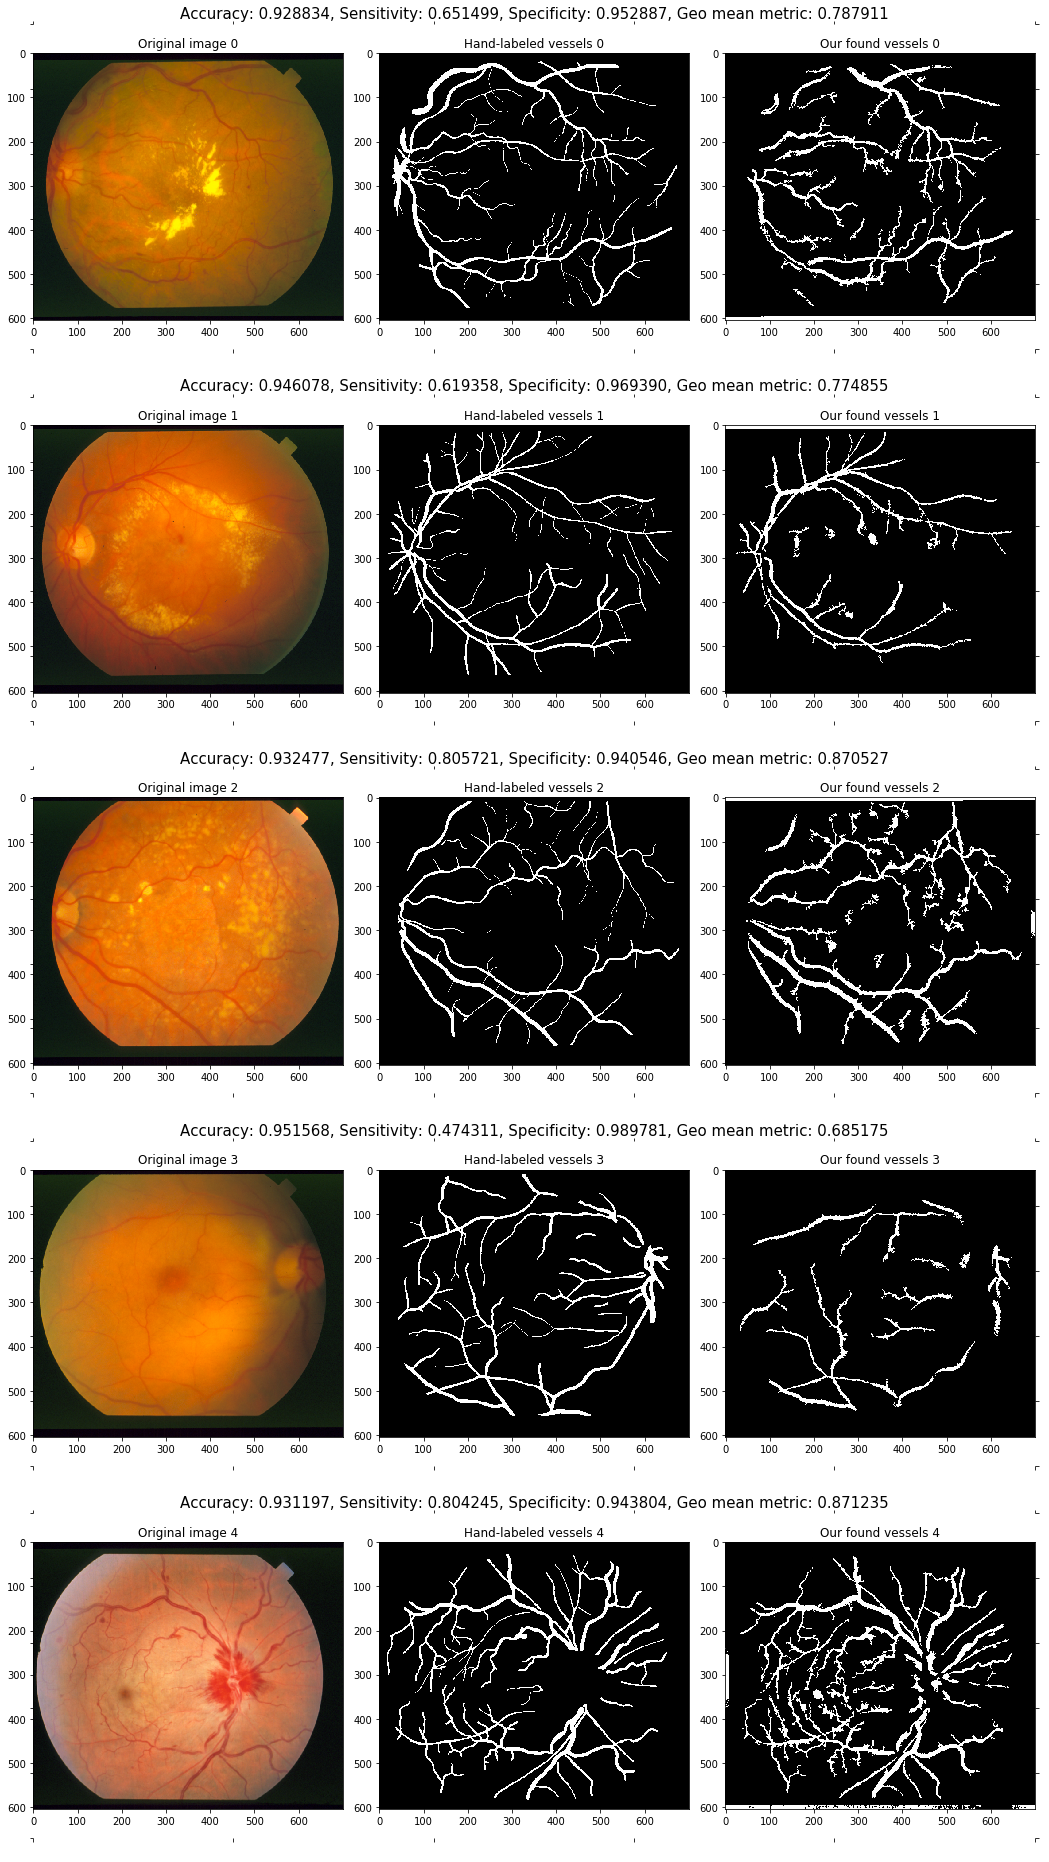

In [230]:
columns = 3
rows = 5

fig, big_axes = plt.subplots( figsize=(15, 26) , nrows=rows, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Accuracy: %f, Sensitivity: %f, Specificity: %f, Geo mean metric: %f"%get_metrics(image_labeled_list[row-1], image_processed_list[row-1]), fontsize=15)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if i%3==0:
        img = image_list[int(i/3)]
        plt.title("Original image %d" % int(i/3))
        plt.imshow(img[:,:,::-1])
    elif i%3==1:
        img = image_labeled_list[int(i/3)]
        plt.title("Hand-labeled vessels %d" % int(i/3))
        plt.imshow(img, cmap='gray')
    else:
        img = image_processed_list[int(i/3)]
        plt.title("Our found vessels %d" % int(i/3))
        plt.imshow(img, cmap='gray')

fig.set_facecolor('w')
plt.tight_layout()
plt.show()